# Определение эмоциональной окраски отзывов с сайта Rotten Tomatoes с помощью BERT

## Установка библиотек

In [ ]:
#pip install torch

In [ ]:
#!pip install pytorch-transformers

In [ ]:
#!pip install keras

In [ ]:
#!pip install tensorflow --user --no-warn-script-location

In [ ]:
#pip install --default-timeout=100 future 


In [ ]:
#pip install --user torch==1.8.1+cu111 torchvision==0.9.1+cu111 torchaudio===0.8.1 -f https://download.pytorch.org/whl/torch_stable.html

In [ ]:
#pip install torch_nightly -f https://download.pytorch.org/whl/nightly/cu90/torch_nightly.html

In [ ]:
import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from pytorch_transformers import BertTokenizer, BertConfig
from pytorch_transformers import AdamW, BertForSequenceClassification
from tqdm import tqdm, trange
import pandas as pd
import io
import numpy as np
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

In [ ]:
torch.cuda.is_available()

True

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
if device == 'cpu':
    print('cpu')
else:
    n_gpu = torch.cuda.device_count()
    print(torch.cuda.get_device_name(0))

Tesla K80


## Загрузка данных


Датасет - rotten_tomatoes_critic_reviews.
Ссылка на датасет - https://www.kaggle.com/stefanoleone992/rotten-tomatoes-movies-and-critic-reviews-dataset

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
data_review = pd.read_csv(r'/content/drive/MyDrive/Colab Notebooks/data/rotten_tomatoes_critic_reviews.csv')
data_review.head(5)

,rotten_tomatoes_link,critic_name,top_critic,publisher_name,review_type,review_score,review_date,review_content
0,m/0814255,Andrew L. Urban,False,Urban Cinefile,Fresh,NaN,2010-02-06,A fantasy adventure that fuses Greek mythology...
1,m/0814255,Louise Keller,False,Urban Cinefile,Fresh,NaN,2010-02-06,"Uma Thurman as Medusa, the gorgon with a coiff..."
2,m/0814255,NaN,False,FILMINK (Australia),Fresh,NaN,2010-02-09,With a top-notch cast and dazzling special eff...
3,m/0814255,Ben McEachen,False,Sunday Mail (Australia),Fresh,3.5/5,2010-02-09,Whether audiences will get behind The Lightnin...
4,m/0814255,Ethan Alter,True,Hollywood Reporter,Rotten,NaN,2010-02-10,What's really lacking in The Lightning Thief i...


In [ ]:
sentences = np.concatenate([data_review['review_content'].values])
sentences = ["[CLS] " + str(sentence) + " [SEP]" for sentence in sentences]
sentences

['[CLS] A fantasy adventure that fuses Greek mythology to contemporary American places and values. Anyone around 15 (give or take a couple of years) will thrill to the visual spectacle [SEP]',
 '[CLS] Uma Thurman as Medusa, the gorgon with a coiffure of writhing snakes and stone-inducing hypnotic gaze is one of the highlights of this bewitching fantasy [SEP]',
 '[CLS] With a top-notch cast and dazzling special effects, this will tide the teens over until the next Harry Potter instalment. [SEP]',
 "[CLS] Whether audiences will get behind The Lightning Thief is hard to predict. Overall, it's an entertaining introduction to a promising new world -- but will the consuming shadow of Potter be too big to break free of? [SEP]",
 "[CLS] What's really lacking in The Lightning Thief is a genuine sense of wonder, the same thing that brings viewers back to Hogwarts over and over again. [SEP]",
 "[CLS] It's more a list of ingredients than a movie-magic potion to enjoy from start to finish. [SEP]",


In [ ]:
len(sentences)

1130017

In [ ]:
sentences = sentences[:10000]
len(sentences)

10000

In [ ]:
labels = [[data_review['review_type'][i]] for i in range(10000)]
labels

[['Fresh'],
 ['Fresh'],
 ['Fresh'],
 ['Fresh'],
 ['Rotten'],
 ['Rotten'],
 ['Rotten'],
 ['Fresh'],
 ['Fresh'],
 ['Fresh'],
 ['Fresh'],
 ['Rotten'],
 ['Rotten'],
 ['Fresh'],
 ['Rotten'],
 ['Fresh'],
 ['Fresh'],
 ['Rotten'],
 ['Fresh'],
 ['Rotten'],
 ['Fresh'],
 ['Rotten'],
 ['Rotten'],
 ['Fresh'],
 ['Rotten'],
 ['Rotten'],
 ['Fresh'],
 ['Fresh'],
 ['Rotten'],
 ['Fresh'],
 ['Rotten'],
 ['Rotten'],
 ['Rotten'],
 ['Fresh'],
 ['Fresh'],
 ['Rotten'],
 ['Fresh'],
 ['Fresh'],
 ['Rotten'],
 ['Rotten'],
 ['Fresh'],
 ['Fresh'],
 ['Fresh'],
 ['Fresh'],
 ['Fresh'],
 ['Rotten'],
 ['Rotten'],
 ['Rotten'],
 ['Rotten'],
 ['Rotten'],
 ['Rotten'],
 ['Rotten'],
 ['Rotten'],
 ['Fresh'],
 ['Rotten'],
 ['Rotten'],
 ['Rotten'],
 ['Rotten'],
 ['Rotten'],
 ['Fresh'],
 ['Fresh'],
 ['Rotten'],
 ['Rotten'],
 ['Fresh'],
 ['Rotten'],
 ['Fresh'],
 ['Fresh'],
 ['Rotten'],
 ['Fresh'],
 ['Rotten'],
 ['Rotten'],
 ['Rotten'],
 ['Fresh'],
 ['Rotten'],
 ['Rotten'],
 ['Fresh'],
 ['Fresh'],
 ['Rotten'],
 ['Fresh'],
 ['Fresh']

In [ ]:
for i in range(len(labels)):
    if labels[i]==['Fresh']:
        labels[i]=[1]
    else:
        labels[i] = [0]
len(labels)

10000

In [ ]:
labels

[[1],
 [1],
 [1],
 [1],
 [0],
 [0],
 [0],
 [1],
 [1],
 [1],
 [1],
 [0],
 [0],
 [1],
 [0],
 [1],
 [1],
 [0],
 [1],
 [0],
 [1],
 [0],
 [0],
 [1],
 [0],
 [0],
 [1],
 [1],
 [0],
 [1],
 [0],
 [0],
 [0],
 [1],
 [1],
 [0],
 [1],
 [1],
 [0],
 [0],
 [1],
 [1],
 [1],
 [1],
 [1],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [1],
 [0],
 [0],
 [0],
 [0],
 [0],
 [1],
 [1],
 [0],
 [0],
 [1],
 [0],
 [1],
 [1],
 [0],
 [1],
 [0],
 [0],
 [0],
 [1],
 [0],
 [0],
 [1],
 [1],
 [0],
 [1],
 [1],
 [0],
 [1],
 [0],
 [0],
 [0],
 [1],
 [0],
 [1],
 [0],
 [1],
 [1],
 [0],
 [0],
 [0],
 [1],
 [0],
 [1],
 [1],
 [0],
 [1],
 [1],
 [0],
 [1],
 [0],
 [1],
 [1],
 [1],
 [1],
 [1],
 [0],
 [0],
 [1],
 [0],
 [0],
 [0],
 [0],
 [0],
 [1],
 [1],
 [1],
 [0],
 [1],
 [1],
 [1],
 [0],
 [0],
 [1],
 [1],
 [0],
 [1],
 [1],
 [0],
 [0],
 [1],
 [1],
 [0],
 [0],
 [1],
 [1],
 [1],
 [0],
 [0],
 [0],
 [1],
 [0],
 [1],
 [1],
 [0],
 [0],
 [1],
 [0],
 [1],
 [1],
 [1],
 [1],
 [1],
 [1],
 [1],
 [1],
 [1],
 [0],
 [1],
 [1],
 [1],
 [1],
 [1],
 [0]

In [ ]:
assert len(sentences) == len(labels)

In [ ]:
from sklearn.model_selection import train_test_split

train_sentences, test_sentences, train_gt, test_gt = train_test_split(sentences, labels, test_size=0.3)

In [ ]:
print(len(train_gt), len(test_gt))

7000 3000


## Inputs

In [ ]:
from pytorch_transformers import BertTokenizer, BertConfig


tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

tokenized_texts = [tokenizer.tokenize(sent) for sent in train_sentences]
print (tokenized_texts[0])

['[CLS]', '.', '.', '.', '[', 'ridley', ']', 'scott', "'", 's', 'most', 'entertaining', 'and', 'involving', 'effort', 'since', '2001', "'", 's', 'black', 'hawk', 'down', '.', '[SEP]']


In [ ]:
train_sentences[0]

"[CLS] ...[Ridley] Scott's most entertaining and involving effort since 2001's Black Hawk Down. [SEP]"

In [ ]:
input_ids = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_texts]
input_ids = pad_sequences(
    input_ids,
    maxlen=100,
    dtype="long",
    truncating="post",
    padding="post"
)
attention_masks = [[float(i>0) for i in seq] for seq in input_ids]

In [ ]:
train_inputs, validation_inputs, train_labels, validation_labels = train_test_split(
    input_ids, train_gt, 
    random_state=42,
    test_size=0.1
)

train_masks, validation_masks, _, _ = train_test_split(
    attention_masks,
    input_ids,
    random_state=42,
    test_size=0.1
)

In [ ]:
train_inputs = torch.tensor(train_inputs).to(torch.int64)
train_labels = torch.tensor(train_labels).to(torch.int64)
train_masks = torch.tensor(train_masks).to(torch.int64)

In [ ]:
validation_inputs = torch.tensor(validation_inputs).to(torch.int64)
validation_labels = torch.tensor(validation_labels).to(torch.int64)
validation_masks = torch.tensor(validation_masks).to(torch.int64)

In [ ]:
train_labels

tensor([[1],
        [1],
        [1],
        ...,
        [1],
        [0],
        [1]])

In [ ]:
train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_dataloader = DataLoader(
    train_data,
    sampler=RandomSampler(train_data),
    batch_size=32
)

In [ ]:
validation_data = TensorDataset(validation_inputs, validation_masks, validation_labels)
validation_dataloader = DataLoader(
    validation_data,
    sampler=SequentialSampler(validation_data),
    batch_size=32
)

## Обучение модели

Загружаем [BertForSequenceClassification](https://github.com/huggingface/pytorch-pretrained-BERT/blob/master/pytorch_pretrained_bert/modeling.py#L1129):

In [ ]:
from pytorch_transformers import AdamW, BertForSequenceClassification

Аналогичные модели есть и для других задач:

In [ ]:
from pytorch_transformers import BertForQuestionAnswering, BertForTokenClassification

In [ ]:
model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=2)
model.cuda()

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

In [ ]:
param_optimizer = list(model.named_parameters())
no_decay = ['bias', 'gamma', 'beta']
optimizer_grouped_parameters = [
    {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.01},
    {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.0}
]

optimizer = AdamW(optimizer_grouped_parameters, lr=3e-5)



In [ ]:
import gc

In [ ]:
gc.collect()

torch.cuda.empty_cache()

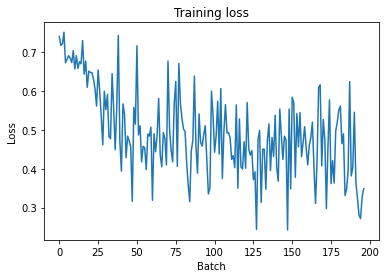

Loss на обучающей выборке: 0.49510
Процент правильных предсказаний на валидационной выборке: 81.86%


In [ ]:
from IPython.display import clear_output

# Будем сохранять loss во время обучения
# и рисовать график в режиме реального времени
train_loss_set = []
train_loss = 0


# Обучение
# Переводим модель в training mode
model.train()


for step, batch in enumerate(train_dataloader):
    
    # gc.collect()

    # torch.cuda.empty_cache()
    
    
    # добавляем батч для вычисления на GPU
    batch = tuple(t.to(device) for t in batch)
    # Распаковываем данные из dataloader
    b_input_ids, b_input_mask, b_labels = batch
    
    # если не сделать .zero_grad(), градиенты будут накапливаться
    optimizer.zero_grad()
    
    # Forward pass
    loss = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask, labels=b_labels)

    train_loss_set.append(loss[0].item())  
    
    # Backward pass
    loss[0].backward()
    
    # Обновляем параметры и делаем шаг используя посчитанные градиенты
    optimizer.step()

    # Обновляем loss
    train_loss += loss[0].item()
    
    # Рисуем график
    clear_output(True)
    plt.plot(train_loss_set)
    plt.title("Training loss")
    plt.xlabel("Batch")
    plt.ylabel("Loss")
    plt.show()
    
print("Loss на обучающей выборке: {0:.5f}".format(train_loss / len(train_dataloader)))


# Валидация
# Переводим модель в evaluation mode
model.eval()

valid_preds, valid_labels = [], []

for batch in validation_dataloader:   
    # добавляем батч для вычисления на GPU
    batch = tuple(t.to(device) for t in batch)
    
    # Распаковываем данные из dataloader
    b_input_ids, b_input_mask, b_labels = batch
    
    # При использовании .no_grad() модель не будет считать и хранить градиенты.
    # Это ускорит процесс предсказания меток для валидационных данных.
    with torch.no_grad():
        logits = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)

    # Перемещаем logits и метки классов на CPU для дальнейшей работы
    logits = logits[0].detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()
    
    batch_preds = np.argmax(logits, axis=1)
    batch_labels = np.concatenate(label_ids)     
    valid_preds.extend(batch_preds)
    valid_labels.extend(batch_labels)

print("Процент правильных предсказаний на валидационной выборке: {0:.2f}%".format(
    accuracy_score(valid_labels, valid_preds) * 100
))

In [ ]:
print("Процент правильных предсказаний на валидационной выборке: {0:.2f}%".format(
    accuracy_score(valid_labels, valid_preds) * 100
))

Процент правильных предсказаний на валидационной выборке: 81.86%


# Оценка качества на отложенной выборке

In [ ]:
tokenized_texts = [tokenizer.tokenize(sent) for sent in test_sentences]
input_ids = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_texts]

input_ids = pad_sequences(
    input_ids,
    maxlen=100,
    dtype="long",
    truncating="post",
    padding="post"
)

In [ ]:
attention_masks = [[float(i>0) for i in seq] for seq in input_ids]

prediction_inputs = torch.tensor(input_ids).to(torch.int64)
prediction_masks = torch.tensor(attention_masks).to(torch.int64)
prediction_labels = torch.tensor(test_gt).to(torch.int64)

prediction_data = TensorDataset(
    prediction_inputs,
    prediction_masks,
    prediction_labels
)

prediction_dataloader = DataLoader(
    prediction_data, 
    sampler=SequentialSampler(prediction_data),
    batch_size=32
)

In [ ]:
model.eval()
test_preds, test_labels = [], []

for batch in prediction_dataloader:
    # добавляем батч для вычисления на GPU
    batch = tuple(t.to(device) for t in batch)
    
    # Распаковываем данные из dataloader
    b_input_ids, b_input_mask, b_labels = batch
    
    # При использовании .no_grad() модель не будет считать и хранить градиенты.
    # Это ускорит процесс предсказания меток для тестовых данных.
    with torch.no_grad():
        logits = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)

    # Перемещаем logits и метки классов на CPU для дальнейшей работы
    logits = logits[0].detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()

    # Сохраняем предсказанные классы и ground truth
    batch_preds = np.argmax(logits, axis=1)
    batch_labels = np.concatenate(label_ids)  
    test_preds.extend(batch_preds)
    test_labels.extend(batch_labels)

In [ ]:
acc_score = accuracy_score(test_labels, test_preds)
print('Процент правильных предсказаний на отложенной выборке составил: {0:.2f}%'.format(
    acc_score*100
))

Процент правильных предсказаний на отложенной выборке составил: 81.23%


In [ ]:
# print('Неправильных предсказаний: {0}/{1}'.format(
#     sum(test_labels != test_preds),
#     len(test_labels)
# ))

In [ ]:
import pickle



# save
with open('/content/drive/MyDrive/Colab Notebooks/data/model.pkl','wb') as f:
    pickle.dump(model,f)



# load
# with open('model.pkl', 'rb') as f:
#     model = pickle.load(f)

In [ ]:
with open('/content/drive/MyDrive/Colab Notebooks/data/model.pkl','rb') as f:
    model_ = pickle.load(f)

In [ ]:
model_.eval()
test_preds, test_labels = [], []

for batch in prediction_dataloader:
    # добавляем батч для вычисления на GPU
    batch = tuple(t.to(device) for t in batch)
    
    # Распаковываем данные из dataloader
    b_input_ids, b_input_mask, b_labels = batch
    
    # При использовании .no_grad() модель не будет считать и хранить градиенты.
    # Это ускорит процесс предсказания меток для тестовых данных.
    with torch.no_grad():
        logits = model_(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)

    # Перемещаем logits и метки классов на CPU для дальнейшей работы
    logits = logits[0].detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()

    # Сохраняем предсказанные классы и ground truth
    batch_preds = np.argmax(logits, axis=1)
    batch_labels = np.concatenate(label_ids)  
    test_preds.extend(batch_preds)
    test_labels.extend(batch_labels)

In [ ]:
acc_score = accuracy_score(test_labels, test_preds)
print('Процент правильных предсказаний на отложенной выборке составил: {0:.2f}%'.format(
    acc_score*100
))

Процент правильных предсказаний на отложенной выборке составил: 81.23%
